In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
class metropolis:
    def __init__(self, N, J=1, B=0):
        self.init_random = np.random.random((N, N))
        self.grid_n = np.zeros((N, N))
        self.grid_n[self.init_random >= .75] = 1
        self.grid_n[self.init_random <= .75] = -1
    
    def plot(self):
        plt.imshow(self.grid_n, cmap='binary')

In [9]:
test = metropolis(N=50)

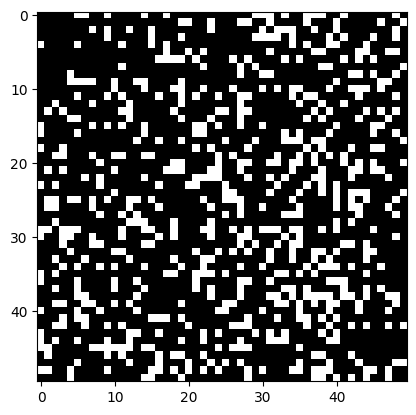

In [10]:
test.plot()